In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb


def add_strong_features(df):
    # Core run-related (usually the strongest predictors)
    
    df['run_diff'] = df['R'] - df['RA']
    
    df['run_diff_per_game'] = df['run_diff'] / df['G']
    
    # Pythagorean (modern exponent)
    exp = 1.86
    df['pyth_exp'] = np.where(
        df['R'] + df['RA'] > 0,
        df['R']**exp / (df['R']**exp + df['RA']**exp),
        0.5
    )
    df['pyth_wins'] = np.round(df['G'] * df['pyth_exp']).astype(int)
    
   
    """
    # Per-game rates (helps across eras)
    df['R_per_game']  = df['R'] / df['G']
    df['RA_per_game'] = df['RA'] / df['G']
    
    # Pitching quality
    df['IP'] = df['IPouts'] / 3.0 + 1e-6          # avoid division by zero
    df['SOA_per_game'] = df['SOA'] / df['IP']
    df['WHIP'] = (df['HA'] + df['BBA']) / df['IP']
    """
    # Other useful differentials & adjustments
    df['HR_diff'] = df['HR'] - df['HRA']
    df['ERA_adj'] = df['ERA'] - df['mlb_rpg'] * 9     # rough league adjustment
    
    # Late-game / bullpen strength
    # df['SV_rate'] = df['SV'] / (df['SV'] + df['BS'] + 1e-6)  # if you have blown saves
    """
    # Market/team quality proxy
    #df['attendance_per_game'] = df['attendance'] / df['G']
    """
    return df

# Load the pre-processed train and test datasets
#DATAPATH = "sctpdsai-m-3-ds-3-coaching-money-ball-analytics"
BASE = f"input/"
data_df = pd.read_csv(os.path.join(BASE, "data.csv"))
predict_df = pd.read_csv(os.path.join(BASE, "predict.csv"))

# Display basic information about the datasets
print(f"Data set shape: {data_df.shape}")
print(f"Predict set shape: {predict_df.shape}")



Data set shape: (1812, 51)
Predict set shape: (453, 45)


In [144]:
default_features = [
"""
    # Basic Statistics
    'G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'SV',
    'RA', 'ER', 'ERA', 'CG', 'SHO', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
    'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF', #30
"""
    # Clean Statistics
    'G', 'R', 'AB', 'H'             , 'HR'      , 'SO', 'SB',                    'SV',
        'ER', 'ERA', 'CG', 'SHO', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 
    'E', 'DP', 'FP', #20
    
    # Derived Features
   # 'R_per_game', 'RA_per_game', 'mlb_rpg', 'pyth_wins', 'run_diff_per_game', #5

    # Derived Clean Features
                                  'mlb_rpg', 'pyth_wins', 'run_diff_per_game', #3
    
    # Era Indicators
    #'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8',  #8

    # Era Clean Indicators
                                                           'era_7', 'era_8', #2
    
    """
    # Decade Indicators
    'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
    'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010' #11
    """
    # Decade Clean Indicators
    'decade_1910',                'decade_1930', 'decade_1940', 'decade_1950',
    'decade_1960', 'decade_1970',                               'decade_2000' #7
    
]

strong_features = ['pyth_wins', 'run_diff_per_game', 'RA', 'ERA', 'IPouts', 'SV', 'SOA', #'mlb_rpg', 'era_8',          
                    'CG', 'HA',  'DP', 'FP',  
                   # 'decade_1910',                
                   # 'decade_1930', 
                   # 'decade_1940', 
                    'decade_1950',
                   # 'decade_1960', 
                   # 'decade_1970',                               
                   # 'decade_2000'  
                              
                   ]

data_df   = add_strong_features(data_df)
predict_df = add_strong_features(predict_df)

# Filter features that exist in both datasets
available_features = [col for col in default_features if col in data_df.columns and col in predict_df.columns]
print(f"Number of available default features: {len(available_features)}")
print(available_features)



# Separate features and target variable
#X = data_df[available_features]
X = data_df[strong_features]
y = data_df['W']

# Perform the split (adjust test_size / random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% for testing
    random_state=42    # ensures reproducibility
)

Number of available default features: 30
['R', 'AB', 'H', 'HR', 'SO', 'SB', 'SV', 'ER', 'ERA', 'CG', 'SHO', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'mlb_rpg', 'pyth_wins', 'run_diff_per_game', 'era_7', 'era_8', 'decade_1930', 'decade_1940', 'decade_1950', 'decade_1960', 'decade_1970', 'decade_2000']


In [99]:

# Scale features
# Identify columns to exclude from scaling (one-hot encoded and label columns)
one_hot_cols = [col for col in X_train.columns if col.startswith(('era_', 'decade_'))]
other_cols = [col for col in X_train.columns if col not in one_hot_cols]

# Scale only non-one-hot features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[other_cols] = scaler.fit_transform(X_train[other_cols])
X_test_scaled[other_cols] = scaler.transform(X_test[other_cols])

In [147]:
# Build Linear Regression Model
"""
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_train_preds = lr.predict(X_train_scaled)
lr_test_preds = lr.predict(X_test_scaled)
"""
"""
alphas = np.logspace(-4, 2, 30)  # try many penalties
ridge = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_absolute_error')
ridge.fit(X_train_scaled[available_features], y_train)
"""

model = xgb.XGBRegressor(
    n_estimators           = 15000,
    learning_rate          = 0.0015,           # ← much slower
    max_depth              = 3,                # ← very shallow
    min_child_weight       = 12,               # ← strong regularization
    gamma                  = 0.2,
    subsample              = 0.75,
    colsample_bytree       = 0.65,
    reg_lambda             = 12.0,             # stronger L2
    reg_alpha              = 3.0,
    random_state           = 42,
    tree_method            = 'hist',
    eval_metric            = 'mae',
    early_stopping_rounds  = 200               # more patient
)

model.fit(
    X_train[strong_features], y_train,
    eval_set      = [(X_test[strong_features], y_test)],
    verbose       = 400
)

[0]	validation_0-mae:10.31636
[400]	validation_0-mae:6.68912
[800]	validation_0-mae:4.81087
[1200]	validation_0-mae:3.86686
[1600]	validation_0-mae:3.43774
[2000]	validation_0-mae:3.27272
[2400]	validation_0-mae:3.19347
[2800]	validation_0-mae:3.15990
[3200]	validation_0-mae:3.14279
[3600]	validation_0-mae:3.12969
[4000]	validation_0-mae:3.12051
[4400]	validation_0-mae:3.11544
[4800]	validation_0-mae:3.11465
[4813]	validation_0-mae:3.11446


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.65, device=None, early_stopping_rounds=200,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0015, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=12, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=15000,
             n_jobs=None, num_parallel_tree=None, ...)

In [148]:
# Evaluate Linear Regression
"""
lr_train_mae = mean_absolute_error(y_train, lr_train_preds)
lr_test_mae = mean_absolute_error(y_test, lr_test_preds)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_preds))
lr_test_r2 = r2_score(y_test, lr_test_preds)

print(f"Linear Regression Performance:")
print(f"  Training MAE: {lr_train_mae:.4f}")
print(f"  Test MAE: {lr_test_mae:.4f}")
print(f"  Test RMSE: {lr_test_rmse:.4f}")
print(f"  Test R²: {lr_test_r2:.4f}")

# Feature importance from Linear Regression
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))
"""
"""
print("Best alpha:", ridge.alpha_)
print("Best CV score (negative MAE):", ridge.best_score_)  # e.g., -2.85 means MAE ≈ 2.85

test_mae = mean_absolute_error(y_test, ridge.predict(X_test_scaled))
print("Test MAE:", test_mae)
"""
# Evaluate
print("Best iteration:", model.best_iteration)
print("Train MAE:", mean_absolute_error(y_train, model.predict(X_train)))
print("Test MAE :", mean_absolute_error(y_test,  model.predict(X_test)))


Best iteration: 4613
Train MAE: 2.6966517430654964
Test MAE : 3.114115155432835


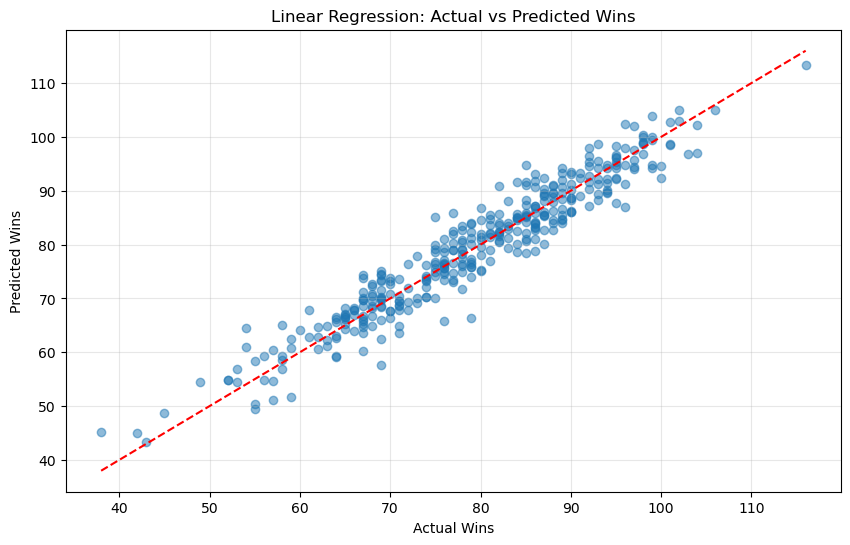

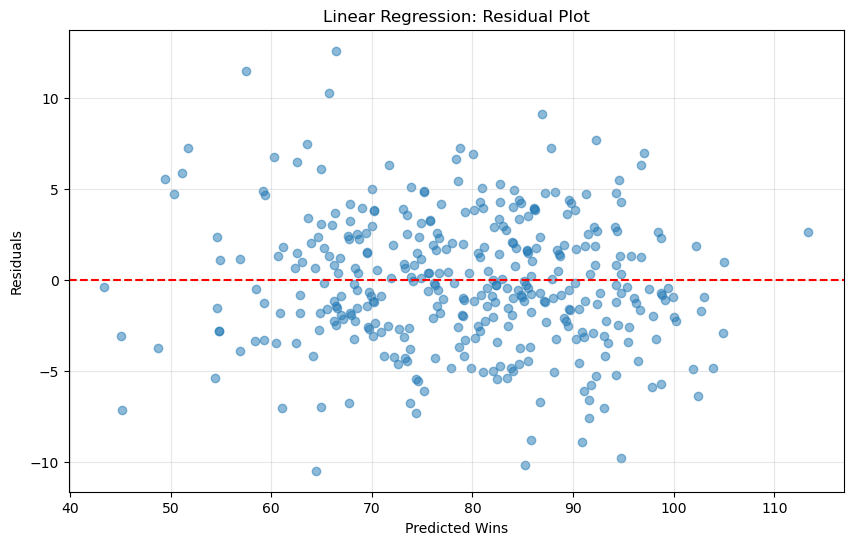

In [239]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Linear Regression: Actual vs Predicted Wins')
plt.grid(True, alpha=0.3)

# Add residual plot
plt.figure(figsize=(10, 6))
residuals = y_test - lr_test_preds
plt.scatter(lr_test_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot')
plt.grid(True, alpha=0.3)
plt.show()

In [220]:
# Prepare Submission

# Align features and scale using the previously fitted scaler
predict_scaled = predict_df[available_features].copy()
predict_scaled[other_cols] = scaler.transform(predict_scaled[other_cols])

# Predict wins for the new dataset
#predict_preds = lr.predict(predict_scaled)
predict_preds = ridge.predict(predict_scaled)

# Build submission in the same format as submission.csv
submission_df = pd.DataFrame({
    'ID': predict_df['ID'],
    'W': np.round(predict_preds).astype(int)
})

submission_path = 'submission_predict.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Kaggle submission saved to {submission_path}")

Kaggle submission saved to submission_predict.csv


In [125]:
X_full = data_df[available_features]
y_full = data_df['W']

scaler_final = StandardScaler()
X_full_scaled = scaler_final.fit_transform(X_full)

# Train on everything
ridge_final = RidgeCV(
    alphas=np.logspace(-2, 4, 50),
    cv=5,
    scoring='neg_mean_absolute_error'
)

ridge_final.fit(X_full_scaled, y_full)

print("Final model trained on full data! Best alpha:", ridge_final.alpha_)

Final model trained on full data! Best alpha: 1.5998587196060574


In [127]:
# After training ridge_final and scaler_final on full data
features_used = available_features
# Prepare submission data
#predict_df = add_strong_features(predict_df)           # add pyth_wins etc. if needed
X_submission = predict_df[features_used].copy()

# Scale everything consistently
X_submission_scaled = scaler_final.transform(X_submission)

# Predict
predict_preds = ridge_final.predict(X_submission_scaled)

# Build & save submission
submission_df = pd.DataFrame({
    'ID': predict_df['ID'],
    'W': np.round(predict_preds).astype(int)
})

submission_df.to_csv('submission_final.csv', index=False)
print("Submission created! Shape:", submission_df.shape)
print(submission_df.head())

Submission created! Shape: (453, 2)
     ID   W
0  1756  70
1  1282  74
2   351  84
3   421  87
4    57  93
